In [1]:
!pip install --upgrade pandas --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple


In [2]:
!pip install --upgrade numpy --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple


In [3]:
!pip install awswrangler --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple
  Using cached https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/packages/packages/72/4d/b45ac72620e0232706e78c0e92a28f7244d810b46762b20c25ac354974dc/awswrangler-2.17.0-py3-none-any.whl (251 kB)
  Using cached https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/packages/packages/35/76/85a776cfd7666588f5daf8dad9b652e8bf6d45b688cd9c44e2712b292cdc/gremlinpython-3.6.1-py2.py3-none-any.whl (73 kB)
  Using cached https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/packages/packages/a5/dd/fc1372e19edffa0ef38ff4ea243f79101d69cf899a320e95166557ab0bf7/pg8000-1.29.3-py3-none-any.whl (51 kB)
  Using cached https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/packages/packages/df/73/b6e24bd22e6720ca8ee9a85a0c4a2971af8497d8f3193fa05390cbd46e09/backoff-2.2.1-py3-none-any

In [4]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import warnings
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import boto3
import io

pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [5]:
s3 = boto3.client('s3')

# Mention the bucket name where raw data is present
bucket='adl-core-sagemaker-studio'

# This is used to seperate different versions of data for whole lifecycle i.e., data pre-process, transformations, modeling and inferences.
# Mention the version whre data is stored in given S3 bucket
version = 'version-1'

# Mention the correct directory where raw-data is present, if data is in multiple files make sure all files are present in this directory
raw_data_path = f'external/artichauhan/Pre-Diabetes/Raw Data'

raw_data_fnames = ['Hype_ML_demographics_19_20_21_1.csv','Hype_ML_demographics_19_20_21_2.csv']

s3://adl-core-sagemaker-studio/external/artichauhan/Pre-Diabetes/Raw Data/data in parquet format/

In [6]:
# # Retrieve the list of existing buckets
# s3 = boto3.client("s3")
# response = s3.list_buckets()

# # Output the bucket names
# print("Existing buckets:")
# for bucket in response['Buckets']:
#     print(f'{bucket["Name"]}')

In [7]:
# df = dd.read_parquet(f's3://{bucket}/{raw_data_path}/data in parquet format/*.parquet')
# #converting dask df to pandas df 
# df = df.compute()
# df.head()

In [8]:
import awswrangler as wr
df = wr.s3.read_parquet(f's3://{bucket}/{raw_data_path}/data in parquet format/*.parquet')

In [9]:
df.shape

(664653, 67)

In [10]:
# df['pre_diabetic_label'].unique()

In [11]:
len(df[df['pre_diabetic_label'] == 'NULL']['pre_diabetic_label'])

0

In [12]:
round(len(df[df['pre_diabetic_label'] == 'NULL']['pre_diabetic_label'])/len(df.index),2)

0.0

In [13]:
df.isna().sum()

person_internal_id        0
partneremployerid         0
patient_key               0
pre_diabetic_label        0
tot_billed_amt_yr_0       0
                         ..
physician_ind_y1          0
outpatient_ind_y1         0
unknown_ind_y1            0
durable_medical_ind_y1    0
lab_visit_ind_y1          0
Length: 67, dtype: int64

In [14]:
threshold = 0.1
na_col = df.isna().sum().div(len(df.index))              # average na by column
cols = na_col[na_col > threshold].keys().to_list() 
print(cols)

[]


In [15]:
def load_data_from_s3(bucket,raw_data_path,raw_data_fnames):
    s3 = boto3.client('s3')
    dataset_nrows = []
    for i, fname in enumerate(raw_data_fnames):
        if i==0:
            print(f'Reading file: {fname}')
            key = f'{raw_data_path}/{fname}'
            obj = s3.get_object(Bucket=bucket, Key=key)
            data = pd.read_csv(io.BytesIO(obj['Body'].read()))
            dataset_nrows.append(data.shape[0])
            print(f'\tFile read successfully | Shape: {data.shape}')
        else:
            print(f'Reading file: {fname}')
            key = f'{raw_data_path}/{fname}'
            obj = s3.get_object(Bucket=bucket, Key=key)
            data2 = pd.read_csv(io.BytesIO(obj['Body'].read()))
            data = data.append(data2,ignore_index=True)
            dataset_nrows.append(data2.shape[0])
            print(f'\tFile read successfully | Shape: {data2.shape}')

    if sum(dataset_nrows) == data.shape[0]:
        print(f'Data from all files loaded successfully | Final Shape: {data.shape}')
        return data.copy()
    else:
        print('There is discrepency in numbers')
        print(f'\tTotal number of rows combined in all files: {sum(dataset_nrows)}')
        print(f'\tAfter combining all files total number of rows are: {data.shape[0]}')
        return None

In [16]:
data_path = f'{raw_data_path}/Demographics files'
demo_df = load_data_from_s3(bucket,data_path,raw_data_fnames)

Reading file: Hype_ML_demographics_19_20_21_1.csv
	File read successfully | Shape: (2242551, 35)
Reading file: Hype_ML_demographics_19_20_21_2.csv
	File read successfully | Shape: (2082214, 35)
Data from all files loaded successfully | Final Shape: (4324765, 35)


In [17]:
demo_df.head(2)

,person_internal_id,client_id,udp_global_id,age,gender,marital_status,is_union,primary_language_code,country_description,state,platform_indicator_code,mapped_employment_status_code,mapped_employment_status_description,mapped_fullpart_code,mapped_fullpart_description,mapped_high_compensation_code,mapped_high_compensation_description,mapped_permanent_temporary_code,mapped_permanent_temporary_description,mapped_hourly_salary_code,mapped_hourly_salary_description,subsidiary_code,subsidiary_description,mapped_flex_status_code,mapped_flex_status_description,original_hire_date,rehire_date,is_rehire,termination_date,base_pay_regular_payrate_amount,base_pay_regular_frequency_code,base_pay_regular_frequency_description,base_pay_regular_expectedannualsalary,base_pay_regular_expectedannualsalary_range,annual_benefits_base_rate
0,359000077,3349,58a39c4f042fec2f071a7119,74.0,F,S,N,NaN,United States of America,TX,R4,RTEE,Retired,FLTM,Full Time,NaN,NaN,PERM,Permanent,NaN,NaN,NaN,NaN,ELIGIBLE,Eligible,1970-02-27,NaN,N,2299-12-31,35626.50,A1,Annual,35626.50,"$20,000-$39,999",NaN
1,231200007,3955,59056881dab54b31271989ea,58.0,M,M,N,AE,United States of America,MD,R4,ACTIVE,Active,FLTM,Full Time,NaN,NaN,PERM,Permanent,NaN,NaN,NaN,NaN,ELIGIBLE,Eligible,NaN,NaN,N,2299-12-31,104499.24,A1,Annual,104499.24,"$100,000-$174,999",NaN


In [18]:
demo_df['client_pid'] = demo_df['client_id'].astype(str) + '/' +  demo_df['person_internal_id'].astype(str)

In [19]:
df['client_pid'] = df['partneremployerid'].astype(str) + '/' +  df['person_internal_id'].astype(str)

In [20]:
pd_df = df.merge(demo_df,how='left',on='client_pid')

In [21]:
pd_df.head(2)

,person_internal_id_x,partneremployerid,patient_key,pre_diabetic_label,tot_billed_amt_yr_0,avg_billed_amt_yr_0,std_billed_amt_yr_0,max_billed_amt_yr_0,employer_paid_yr_0,employee_paid1_yr_0,employee_paid2_yr_0,paid_thr_deduct_yr_0,tot_billed_amt_yr_1,avg_billed_amt_yr_1,std_billed_amt_yr_1,max_billed_amt_yr_1,employer_paid_yr_1,employee_paid1_yr_1,employee_paid2_yr_1,paid_thr_deduct_yr_1,tot_billed_amt_yr,avg_billed_amt_yr,std_billed_amt_yr,max_billed_amt_yr,employer_paid_yr,employee_paid1_yr,employee_paid2_yr,paid_thr_deduct_yr,screening_flag_yr_0,sleep_apnea_flag_yr_0,cushing_flag_yr_0,acromegaly_flag_yr_0,urinary_flag_yr_0,screening_flag_yr_1,sleep_apnea_flag_yr_1,cushing_flag_yr_1,acromegaly_flag_yr_1,urinary_flag_yr_1,screening_flag_yr,sleep_apnea_flag_yr,cushing_flag_yr,acromegaly_flag_yr,urinary_flag_yr,specialist_ind,primary_care_ind,inpatient_ind,physician_ind,outpatient_ind,unknown_ind,durable_medical_ind,lab_visit_ind,specialist_ind_y0,primary_care_ind_y0,inpatient_ind_y0,physician_ind_y0,outpatient_ind_y0,unknown_ind_y0,durable_medical_ind_y0,lab_visit_ind_y0,specialist_ind_y1,primary_care_ind_y1,inpatient_ind_y1,physician_ind_y1,outpatient_ind_y1,unknown_ind_y1,durable_medical_ind_y1,lab_visit_ind_y1,client_pid,person_internal_id_y,client_id,udp_global_id,age,gender,marital_status,is_union,primary_language_code,country_description,state,platform_indicator_code,mapped_employment_status_code,mapped_employment_status_description,mapped_fullpart_code,mapped_fullpart_description,mapped_high_compensation_code,mapped_high_compensation_description,mapped_permanent_temporary_code,mapped_permanent_temporary_description,mapped_hourly_salary_code,mapped_hourly_salary_description,subsidiary_code,subsidiary_description,mapped_flex_status_code,mapped_flex_status_description,original_hire_date,rehire_date,is_rehire,termination_date,base_pay_regular_payrate_amount,base_pay_regular_frequency_code,base_pay_regular_frequency_description,base_pay_regular_expectedannualsalary,base_pay_regular_expectedannualsalary_range,annual_benefits_base_rate
0,210000050,2265,78553718,Yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0000,0.000000,0.00,0.00,0.0,0.00,0.00,4505.17,95.854681,147.3198,806.05,3292.51,245.0,267.66,700.0,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,2265/210000050,210000050,2265,593253ee69b312120cd2b1f2,57.0,F,M,N,NaN,NaN,NaN,NaN,TERM,Termination,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOTELIGIBLE,Not Eligible,NaN,NaN,N,2022-03-12,124866.82,A1,Annual,124866.82,"$100,000-$174,999",NaN
1,133200030,1377,76251639,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,573.19,143.2975,142.888152,353.65,204.18,0.0,51.05,317.96,0.00,0.000000,0.0000,0.00,0.00,0.0,0.00,0.0,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,1377/133200030,133200030,1377,597d1d83dab54b2d66db9897,36.0,M,M,N,NaN,United States of America,OH,R3,ACTIVE,Active,FLTM,Full Time,NaN,NaN,PERM,Permanent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,2299-12-31,70075.20,A1,Annual,70075.20,"$60,000-$79,999",70075.2


In [22]:
pd_df.shape

(666085, 103)

In [23]:
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 666085 entries, 0 to 666084
Columns: 103 entries, person_internal_id_x to annual_benefits_base_rate
dtypes: Int32(3), float64(28), int64(2), object(30), string(40)
memory usage: 522.8+ MB


In [24]:
pd_df[['client_id','partneremployerid','person_internal_id_x','person_internal_id_y']]

,client_id,partneremployerid,person_internal_id_x,person_internal_id_y
0,2265,2265,210000050,210000050
1,1377,1377,133200030,133200030
2,1040,1040,297600089,297600089
3,1040,1040,471410079,471410079
4,5977,5977,29100064,29100064
...,...,...,...,...
666080,9086,9086,266500035,266500035
666081,2346,2346,421310001,421310001
666082,1874,1874,202940018,202940018
666083,3349,3349,241390094,241390094


In [25]:
dup_df = pd_df[pd_df['client_pid'].duplicated()==True]

In [26]:
dup_df

,person_internal_id_x,partneremployerid,patient_key,pre_diabetic_label,tot_billed_amt_yr_0,avg_billed_amt_yr_0,std_billed_amt_yr_0,max_billed_amt_yr_0,employer_paid_yr_0,employee_paid1_yr_0,employee_paid2_yr_0,paid_thr_deduct_yr_0,tot_billed_amt_yr_1,avg_billed_amt_yr_1,std_billed_amt_yr_1,max_billed_amt_yr_1,employer_paid_yr_1,employee_paid1_yr_1,employee_paid2_yr_1,paid_thr_deduct_yr_1,tot_billed_amt_yr,avg_billed_amt_yr,std_billed_amt_yr,max_billed_amt_yr,employer_paid_yr,employee_paid1_yr,employee_paid2_yr,paid_thr_deduct_yr,screening_flag_yr_0,sleep_apnea_flag_yr_0,cushing_flag_yr_0,acromegaly_flag_yr_0,urinary_flag_yr_0,screening_flag_yr_1,sleep_apnea_flag_yr_1,cushing_flag_yr_1,acromegaly_flag_yr_1,urinary_flag_yr_1,screening_flag_yr,sleep_apnea_flag_yr,cushing_flag_yr,acromegaly_flag_yr,urinary_flag_yr,specialist_ind,primary_care_ind,inpatient_ind,physician_ind,outpatient_ind,unknown_ind,durable_medical_ind,lab_visit_ind,specialist_ind_y0,primary_care_ind_y0,inpatient_ind_y0,physician_ind_y0,outpatient_ind_y0,unknown_ind_y0,durable_medical_ind_y0,lab_visit_ind_y0,specialist_ind_y1,primary_care_ind_y1,inpatient_ind_y1,physician_ind_y1,outpatient_ind_y1,unknown_ind_y1,durable_medical_ind_y1,lab_visit_ind_y1,client_pid,person_internal_id_y,client_id,udp_global_id,age,gender,marital_status,is_union,primary_language_code,country_description,state,platform_indicator_code,mapped_employment_status_code,mapped_employment_status_description,mapped_fullpart_code,mapped_fullpart_description,mapped_high_compensation_code,mapped_high_compensation_description,mapped_permanent_temporary_code,mapped_permanent_temporary_description,mapped_hourly_salary_code,mapped_hourly_salary_description,subsidiary_code,subsidiary_description,mapped_flex_status_code,mapped_flex_status_description,original_hire_date,rehire_date,is_rehire,termination_date,base_pay_regular_payrate_amount,base_pay_regular_frequency_code,base_pay_regular_frequency_description,base_pay_regular_expectedannualsalary,base_pay_regular_expectedannualsalary_range,annual_benefits_base_rate
93,292501061,3349,78647695,No,0.00,0.000000,0.000000,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.000000,0.00,0.00,0.0,0.0,0.0,239.00,79.666667,48.583262,135.00,0.00,0.0,0.00,239.00,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,3349/292501061,292501061,3349,58a38d50f7a4410c158130ef,78.0,M,M,N,NaN,United States of America,MS,R4,RTEE,Retired,FLTM,Full Time,NaN,NaN,PERM,Permanent,NaN,NaN,NaN,NaN,ELIGIBLE,Eligible,1930-01-01,NaN,N,2299-12-31,NaN,NaN,NaN,NaN,NaN,NaN
113,246401005,3349,77678179,No,0.00,0.000000,0.000000,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.000000,0.00,0.00,0.0,0.0,0.0,4576.10,143.003125,240.858144,963.90,1624.37,0.0,305.56,2646.17,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,No,No,No,Yes,Yes,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,3349/246401005,246401005,3349,607a7ac99a2ea4540a2d695b,55.0,M,S,N,NaN,United States of America,GA,R4,ACTIVE,Active,FLTM,Full Time,NaN,NaN,PERM,Permanent,NaN,NaN,NaN,NaN,ELIGIBLE,Eligible,2021-04-12,NaN,N,2299-12-31,98800.00,A1,Annual,98800.00,"$80,000-$99,999",NaN
765,290401052,3349,77454188,No,0.00,0.000000,0.000000,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.000000,0.00,0.00,0.0,0.0,0.0,4130.74,114.742778,210.184668,1246.00,1079.29,0.0,0.00,3051.45,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,No,No,Yes,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,3349/290401052,290401052,3349,58a38f89f7a4410c1582f13c,87.0,F,M,N,NaN,United States of America,PA,R4,DCSD_INSV,Deceased - In Service,FLTM,Full Time,NaN,NaN,PERM,Permanent,NaN,NaN,NaN,NaN,ELIGIBLE,Eligible,1930-01-01,NaN,N,2299-12-31,NaN,NaN,NaN,NaN,NaN,NaN
843,52050020,5035,77726143,No,0.00,0.000000,0.000000,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.000000,0.00,0.00,0.0,0.0,0.0,194.28,5.112632,7.519340,24.83,18.50,0.0,0.00,175.78,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,Yes,No,Yes,No,No,No,No,No,No,No,No,No,No,No,N

In [27]:
new_pd_df = pd_df

In [28]:
# pd_df.drop_duplicates(keep='first',inplace=True)

In [29]:
# pd_df.shape

In [30]:
pd_df['duplicated'] = pd_df['client_pid'].duplicated()

In [31]:
pd_df['duplicated'].value_counts()

False    664581
True       1504
Name: duplicated, dtype: int64

In [32]:
final_df = pd_df[pd_df['duplicated']!=True]

In [33]:
final_df.shape

(664581, 104)

In [34]:
# for i in final_df.columns:
#     print(i)

In [35]:
columnList = ['duplicated','person_internal_id_y','partneremployerid']
final_df.drop(columns=columnList, axis=1, inplace=True)

In [36]:
final_df.rename(columns={'person_internal_id_x':'person_internal_id'},inplace=True)

In [37]:
final_df.shape

(664581, 101)

In [38]:
final_df['pre_diabetic_label'].value_counts()

No     515047
Yes    149534
Name: pre_diabetic_label, dtype: Int64

In [39]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 664581 entries, 0 to 666084
Columns: 101 entries, person_internal_id to annual_benefits_base_rate
dtypes: Int32(2), float64(28), int64(1), object(30), string(40)
memory usage: 513.4+ MB


In [40]:
# def cat_plot(predictor):
#     df = final_df
#     c = ['rosybrown','dimgray','skyblue','steelblue','salmon','teal','indianred', 'darkturquoise', 'skyblue','olive','firebrick','yellowgreen','maroon','cyan']
#     fig,axes = plt.subplots(2,2,figsize=(15,10))
#     df.groupby(predictor, observed=True, dropna=False, sort=False)['person_internal_id'].count().plot(kind='bar',stacked=True,color='indianred',legend=False,ax=axes[0,0])
#     df.groupby(predictor, observed=True, dropna=False, sort=False)['pre_diabetic_label'].value_counts().unstack().plot(kind='bar',stacked=True,color=c,ax=axes[0,1])
#     plt.legend(bbox_to_anchor =(1, 1), ncol = 2 )
#     plt.show()

In [41]:
final_df.describe()

,person_internal_id,patient_key,tot_billed_amt_yr_0,avg_billed_amt_yr_0,std_billed_amt_yr_0,max_billed_amt_yr_0,employer_paid_yr_0,employee_paid1_yr_0,employee_paid2_yr_0,paid_thr_deduct_yr_0,tot_billed_amt_yr_1,avg_billed_amt_yr_1,std_billed_amt_yr_1,max_billed_amt_yr_1,employer_paid_yr_1,employee_paid1_yr_1,employee_paid2_yr_1,paid_thr_deduct_yr_1,tot_billed_amt_yr,avg_billed_amt_yr,std_billed_amt_yr,max_billed_amt_yr,employer_paid_yr,employee_paid1_yr,employee_paid2_yr,paid_thr_deduct_yr,client_id,age,base_pay_regular_payrate_amount,base_pay_regular_expectedannualsalary,annual_benefits_base_rate
count,6.645810e+05,6.645810e+05,6.645810e+05,664581.000000,664581.000000,6.645810e+05,6.645810e+05,664581.000000,664581.000000,664581.000000,6.645810e+05,664581.000000,664581.000000,6.645810e+05,6.645810e+05,664581.000000,664581.000000,664581.000000,6.645810e+05,664581.000000,664581.000000,6.645810e+05,6.645810e+05,664581.000000,664581.000000,664581.000000,664581.000000,664483.000000,6.292440e+05,6.294500e+05,3.751270e+05
mean,2.493251e+08,6.757271e+07,5.082631e+03,96.929377,251.935553,1.845274e+03,4.338419e+03,41.332333,259.505462,461.529371,3.340721e+03,74.974400,187.500887,1.265180e+03,2.772537e+03,29.524257,200.843026,356.032278,6.620727e+03,122.871924,324.469930,2.411579e+03,5.601812e+03,55.548718,328.785495,621.960771,4013.014877,47.155769,9.003401e+04,9.132704e+04,9.673435e+04
std,1.446100e+08,1.389638e+07,2.549875e+04,195.576988,962.035959,1.150908e+04,2.499800e+04,136.108674,751.761266,787.741437,1.815703e+04,208.412640,795.008803,8.434504e+03,1.764039e+04,114.405820,718.753962,771.891287,2.939217e+04,218.496422,1098.997248,1.408858e+04,2.881221e+04,155.406880,942.334598,925.625208,3191.437167,13.367262,4.191732e+05,4.189331e+05,5.411041e+05
min,1.096000e+03,3.741900e+04,-9.818706e+04,-688.597538,0.000000,-3.240900e+02,-1.004371e+05,-250.000000,-5034.520000,-9494.720000,-1.064651e+05,-11018.395000,0.000000,-8.129090e+03,-1.060451e+05,-1140.000000,-46458.230000,-12633.880000,-1.379117e+05,-15323.518889,0.000000,-1.027400e+02,-1.370656e+05,-400.000000,-5786.460000,-8884.410000,726.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.241500e+08,6.921698e+07,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,4.160400e+02,41.787000,43.704717,1.414800e+02,2.045300e+02,0.000000,0.000000,0.000000,2265.000000,36.000000,4.567500e+04,4.665440e+04,4.542720e+04
50%,2.492500e+08,7.109279e+07,6.808000e+02,53.541429,55.154329,1.784300e+02,3.396300e+02,0.000000,0.000000,121.600000,1.639300e+02,26.229524,23.582896,9.451000e+01,0.000000e+00,0.000000,0.000000,0.000000,1.239020e+03,68.896386,75.394053,2.555700e+02,6.886700e+02,0.000000,0.000000,289.630000,3349.000000,47.000000,8.087040e+04,8.098542e+04,8.580000e+04
75%,3.747101e+08,7.304879e+07,2.631180e+03,104.385000,133.686071,5.823000e+02,1.635260e+03,0.000000,80.080000,591.330000,1.408710e+03,80.466111,90.046551,3.125900e+02,7.191300e+02,0.000000,14.460000,381.570000,3.937700e+03,125.054000,200.057659,9.453100e+02,2.607830e+03,30.000000,171.980000,800.000000,5728.000000,58.000000,1.190340e+05,1.192000e+05,1.284410e+05
max,4.999801e+08,8.127618e+07,2.636617e+06,16115.461667,185127.707935,2.421475e+06,2.632617e+06,12146.570000,84841.060000,28917.340000,2.313374e+06,36086.847500,99500.841376,1.865211e+06,2.309874e+06,3275.920000,143267.510000,28117.030000,3.219357e+06,24394.582500,110551.046644,2.366361e+06,3.211107e+06,4279.600000,193418.870000,18623.100000,34153.000000,222.000000,3.285675e+08,3.285675e+08,3.285675e+08


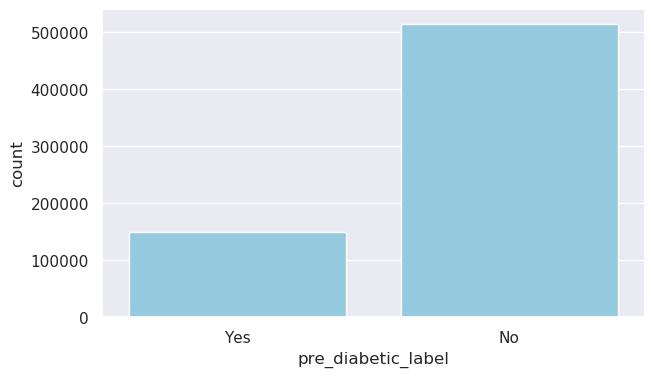

In [42]:
sns.set(rc={'figure.figsize':(7,4)})
sns.countplot(final_df.pre_diabetic_label,color='skyblue')
plt.show()

In [43]:
new_df = final_df.drop(columns=['client_pid','udp_global_id','original_hire_date','rehire_date','termination_date'])

In [44]:
#extract columns
col = new_df.select_dtypes('object').columns
for i in col:
    print(f'value count for {i}')
    print(new_df[i].value_counts())
    print('\n')

value count for gender
M                                            378291
F                                            281382
female                                         1680
male                                           1208
Female                                          945
Male                                            627
Unknown                                         171
U                                               145
Gender_Female                                     9
Undeclared                                        3
Not_declared                                      2
Gender_Male                                       2
D                                                 2
I do not wish to provide this information         1
Not declared                                      1
Name: gender, dtype: int64


value count for marital_status
M                                            366575
S                                            279802
Single                           

In [45]:
def cat_vs_cat_plot(predictor):
    df=final_df
    fig,axes = plt.subplots(1,2,figsize=(15,4))
    df.groupby(predictor, observed=True, dropna=False, sort=False)['person_internal_id'].count().plot(kind='bar',stacked=True,color='skyblue',legend=False,ax=axes[0])
    #df[predictor].value_counts(sort=False).plot(kind='bar',ax=axes[0])
    df.groupby(predictor, observed=True, dropna=False, sort=False)['pre_diabetic_label'].value_counts(normalize=True).unstack().plot(kind='bar',stacked=True,ax=axes[1])
    plt.show()

In [46]:
def cat_vs_count_plot(predictor):
    df=final_df
    fig,axes = plt.subplots(1,2,figsize=(15,4))
    sns.boxplot(data=df, x=predictor, y='pre_diabetic_label', orient='h', ax=axes[0])
    sns.kdeplot(df[df['pre_diabetic_label']==0][predictor], shade=True, label=0, ax=axes[1])
    sns.kdeplot(df[df['pre_diabetic_label']==1][predictor], shade=True, label=1, ax=axes[1])
    plt.title(f'Count of NULL values in {predictor}: {df[predictor].isna().sum()}')
    plt.show()

In [47]:
final_df.select_dtypes('O').columns

Index(['client_pid', 'udp_global_id', 'gender', 'marital_status', 'is_union',
       'primary_language_code', 'country_description', 'state',
       'platform_indicator_code', 'mapped_employment_status_code',
       'mapped_employment_status_description', 'mapped_fullpart_code',
       'mapped_fullpart_description', 'mapped_high_compensation_code',
       'mapped_high_compensation_description',
       'mapped_permanent_temporary_code',
       'mapped_permanent_temporary_description', 'mapped_hourly_salary_code',
       'mapped_hourly_salary_description', 'subsidiary_code',
       'subsidiary_description', 'mapped_flex_status_code',
       'mapped_flex_status_description', 'original_hire_date', 'rehire_date',
       'is_rehire', 'termination_date', 'base_pay_regular_frequency_code',
       'base_pay_regular_frequency_description',
       'base_pay_regular_expectedannualsalary_range'],
      dtype='object')

In [48]:
final_df.isnull().sum()

person_internal_id                                  0
patient_key                                         0
pre_diabetic_label                                  0
tot_billed_amt_yr_0                                 0
avg_billed_amt_yr_0                                 0
                                                ...  
base_pay_regular_frequency_code                 35131
base_pay_regular_frequency_description          35148
base_pay_regular_expectedannualsalary           35131
base_pay_regular_expectedannualsalary_range     35131
annual_benefits_base_rate                      289454
Length: 101, dtype: int64

In [ ]:
for i in final_df.select_dtypes('O').columns:
    print(cat_vs_cat_plot(i))

In [ ]:
#extract columns
def plot_object_col(df): 
    df.select_dtypes('object').columns
    for i in col:
        print(f'\n Count Plot of:{i}')
        sns.set(rc={'figure.figsize':(6,3)})
        plt.yticks(size=10)
        plt.xticks(size=10)
        sns.countplot(x = i,data=df)
        plt.show()

In [ ]:
plot_object_col(new_df)